# 메모리 추가

이제 챗봇은 도구를 사용하여 사용자 질문에 답변할 수 있지만, 이전 대화의 맥락을 기억하지는 못합니다.
이로 인해 일관성 있는 멀티턴 대화를 진행하는 데 제한이 생깁니다.

LangGraph는 이 문제를 `지속적인 체크포인트 저장(persistent checkpointing)` 기능으로 해결합니다.
그래프를 컴파일할 때 checkpointer를 제공하고, 그래프를 호출할 때 thread_id를 함께 전달하면 LangGraph는 각 단계 이후에 상태(state)를 자동으로 저장합니다.
이후 동일한 thread_id를 사용해 그래프를 다시 실행하면, 이전에 저장된 상태를 불러와 챗봇이 마지막 대화 이후부터 이어서 응답할 수 있게 됩니다.

이후에 살펴보겠지만, LangGraph의 체크포인트 기능은 단순한 대화 메모리보다 훨씬 강력합니다.
예를 들어 오류 복구, 사람의 개입이 필요한 워크플로우(human-in-the-loop),
시간을 되돌리는 대화(time travel interaction) 등 복잡한 상태를 저장하고 복원할 수 있게 해줍니다.

하지만 먼저 이번 튜토리얼에서는 멀티턴 대화를 가능하게 하기 위해 체크포인트 기능부터 추가해 보겠습니다.

## 1. 환경 설정

In [ ]:
# 환경 변수 확인
from dotenv import load_dotenv
import os
load_dotenv(override=True)

TAVILY_API_KEY= os.environ.get("TAVILY_API_KEY")
print(TAVILY_API_KEY[:20])

## 2. 챗봇 생성

In [78]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_openai import ChatOpenAI

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearch(max_results=2)
tools = [tool]

def chatbot(state: State):
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    llm_with_tools = llm.bind_tools(tools)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

# 📌 ToolNode 추가
tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

# 
graph_builder.add_conditional_edges(
    "chatbot",
    # 📌 "tools" 또는 END를 리턴한다.
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

## 3. `MemorySaver` 체크포인터 생성

In [79]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

이것은 튜토리얼에 편리하도록 제공되는 `메모리 기반(in-memory) 체크포인터`입니다.
하지만 실제 운영 환경에서는 `SqliteSaver`나 `PostgresSaver`를 사용해 데이터베이스에 연결하여 체크포인트를 저장하는 방식으로 변경하는 것이 일반적입니다.

## 4. 그래프 컴파일

제공된 체크포인터로 그래프를 컴파일합니다. 이 체크포인터는 State그래프가 각 노드를 통과할 때 체크포인트를 생성합니다.

In [80]:
graph = graph_builder.compile(checkpointer=memory)

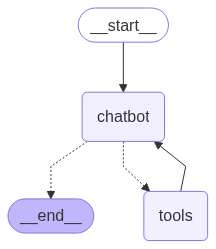

In [81]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

## 5. 챗봇 실행

`thread_id`를 기준으로 LangGraph가 상태(state)를 저장하고 불러오기 때문에 `thread_id`를 선택해서 대화를 시작해야 한다.
즉, thread_id가 같으면 이전 대화의 맥락을 이어서 작동하고,다르면 새로운 대화로 간주합니다.

In [82]:
import uuid

memory_id = str(uuid.uuid4())
config = {"configurable": {"thread_id": memory_id}}

In [83]:
# user_input = "안녕 내 이름은 제이슨이야."

# # config는 stream() 또는 invoke() 함수의 **두 번째 위치 인자(positional argument)**
# events = graph.stream(
#     {"messages": [{"role": "user", "content": user_input}]},
#     config,
#     stream_mode="values",
# )

# for event in events:
#     event["messages"][-1].pretty_print()

In [85]:
# You can exit the chat loop at any time by typing `quit`, `exit`, or `q`.

def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}, config,
                            stream_mode="values",):

        # print(event['messages'][-1], '\n\n')
        event['messages'][-1].pretty_print()

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("또 만나요!")
            break
        stream_graph_updates(user_input)
    except:
        break

User:  안녕


================================ Human Message =================================

안녕
================================== Ai Message ==================================

안녕하세요! 다시 만나서 반갑습니다. 무엇을 도와드릴까요?


User:  반갑다


================================ Human Message =================================

반갑다
================================== Ai Message ==================================

저도 반갑습니다! 오늘은 어떤 이야기를 나눠볼까요?


User:  exit


또 만나요!
